### Network machine learning

I thought of two diffrent machine learning problems for this PPI dataset. One of edge prediction using the given features and labels and one of multi-label classification given the features. I decided to tackle the multilable classification problem since it is one I haven't done before and thought it might be fun!

The simplest method for this problem seems to be binary relevance (BR), BR is what multiclass uses and is one of the more common performance benchmarks. BR assumes independence, so there are a number of ideas about modifying BR to account for label dependence. This involves creating a classifier for each label. There are however methods which do not ignore relationships between labels and this is what i will consider here.

As a note there is also the posssibility to transform the problem into a label powerset problem. Label Powerset is a problem transformation approach to multi-label classification that transforms a multi-label problem to a multi-class problem with 1 multi-class classifier trained on all unique label combinations found in the training data.The method maps each combination to a unique combination id number, and performs multi-class classification using the classifier as multi-class classifier and combination ids as classes. This would be a good idea if the number of classes is not very large since 2^{number of labels}.

In [50]:
import numpy as np
import pandas as pd
import seaborn as sn
import json
import pickle
import networkx as nx
import matplotlib.pyplot as plt
from scipy import sparse

In [3]:
def read_gph(fname):
    # reads a graph from json file
    H = json.load(open(fname, 'r'))
    G = nx.readwrite.json_graph.node_link_graph(H)
    print(fname.replace('/','_').split('_')[1] + ' set') # printing set info
    print('N: %d E: %d' % (G.number_of_nodes(), G.number_of_edges()))      
    return G

### Loading all the given PPI data

first some data pre-processing

In [4]:
# Train data
train_feats = np.load('ppi/train_feats.npy')
train_labels = np.load('ppi/train_labels.npy')
train_graph_id = np.load('ppi/train_graph_id.npy')
train_graph = read_gph('ppi/train_graph.json')

# Test data
test_feats = np.load('ppi/test_feats.npy')
test_labels = np.load('ppi/test_labels.npy')
test_graph_id = np.load('ppi/test_graph_id.npy')
test_graph = read_gph('ppi/test_graph.json')

# Valid data
val_feats = np.load('ppi/valid_feats.npy')
val_labels = np.load('ppi/valid_labels.npy')
val_graph_id = np.load('ppi/valid_graph_id.npy')
val_graph = read_gph('ppi/valid_graph.json')

train set
N: 44906 E: 1271274
test set
N: 5524 E: 167500
valid set
N: 6514 E: 205434


### Information and multilable statistics of the data set

The cardinality of a dataset is the mean number of labels per example and label density takes into consideration the number of labels in the label space (cardinality divided by the number of labels). 

ref: $\textit{CARDINALITY AND DENSITY MEASURES AND THEIR INFLUENCE TO MULTI-LABEL LEARNING METHODS, Bernardini et al.}$

In [10]:
table_data = {'Examples in train set': train_feats.shape[0], 'Examples in test set': test_feats.shape[0],'Examples in val set':val_feats.shape[0],'Features':val_feats.shape[1], 'Labels':val_labels.shape[1], 'Label cardinality':np.sum(train_labels)/train_feats.shape[0] , 'Label density':(np.sum(train_labels)/val_labels.shape[1])/train_feats.shape[0] }
pd.DataFrame(data = table_data,index=['PPI Data'])

,Examples in train set,Examples in test set,Examples in val set,Features,Labels,Label cardinality,Label density
PPI Data,44906,5524,6514,50,121,37.19984,0.307437


I decided to check the cardinalty to confirm wheather it was a sparce multilable problem. This is not the case since the average number of labels for each example is $\approx$37 which means it is not sparse. The label density is also not very low which is good news (I have seen lower!).

Next it is good idea to check the actual label distirbution in the data i.e. is there a 'label' imbalance. Does one subset of labels occur much more often than another one?

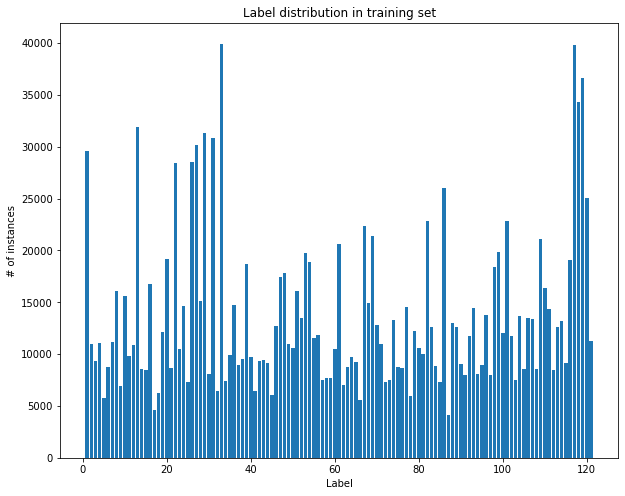

In [11]:
plt.figure(figsize=(10, 8))
plt.bar(np.arange(1,train_labels.shape[1]+1),sum(train_labels))
plt.title('Label distribution in training set')
plt.ylabel('# of instances')
plt.xlabel('Label')
plt.show()

Clearly there is a label imbalance, one label occurs for example nearly 40k times while another only occurs about 4k times. This problem can be tackled by biasing the model to the labels that occur least often.

Th label space is very large here at 121 labels so we can look at some correlations between labels to reduce the label space if possible.

In [12]:
# Return pearson correlation coefficients 
corr = np.absolute(np.corrcoef(train_labels.T))
corr_upper = np.triu(corr, k=1)
inx = np.where(corr_upper >= 0.9)
inx_tuple = np.vstack((inx[0], inx[1])).T # as pairs
inx_unique = np.unique(inx[1]) # indices to remove 
print(inx_unique)

[  6  18  21  26  30  39  46  47  48  49  50  53  54  55  59  60  61  63
  65  69  70  71  72  74  76  77  78  79  80  82  86  89  92  93  94  97
  98  99 101 103 104 108 111 112 113 114 115 119 120]


The array above gives the index location of which labels to remove.

In [13]:
example = train_labels[0,:]
print('Original dim of label space: ', len(example))
reduced_example = [val for n, val in enumerate(example) if n not in inx_unique]
dim_red_label = len(reduced_example)
print('Dim of reduced label space: ', dim_red_label)

Original dim of label space:  121
Dim of reduced label space:  72


In [14]:
# Doing this for all the data

# train data
reduced_train_labels = np.zeros((train_labels.shape[0],dim_red_label))
for each in range(0,train_labels.shape[0]):
    reduced_train_labels[each,:] = [val for n, val in enumerate(train_labels[each,:]) if n not in inx_unique]

# test data
reduced_test_labels = np.zeros((test_labels.shape[0],dim_red_label))
for each in range(0,test_labels.shape[0]):
    reduced_test_labels[each,:] = [val for n, val in enumerate(test_labels[each,:]) if n not in inx_unique]

# val data
reduced_val_labels = np.zeros((val_labels.shape[0],dim_red_label))
for each in range(0,val_labels.shape[0]):
    reduced_val_labels[each,:] = [val for n, val in enumerate(val_labels[each,:]) if n not in inx_unique]

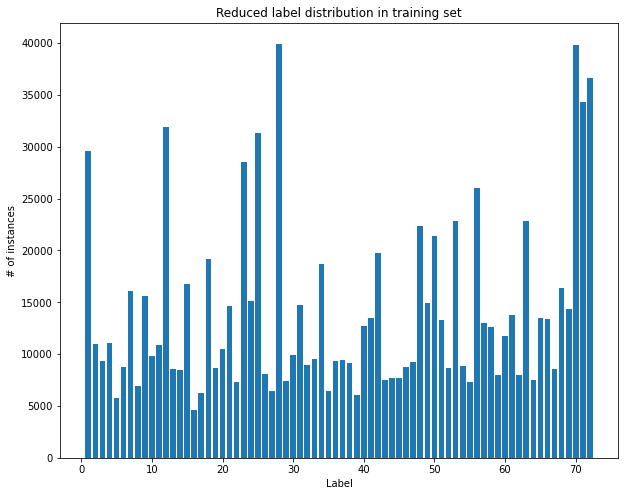

In [15]:
plt.figure(figsize=(10, 8))
plt.bar(np.arange(1,reduced_train_labels.shape[1]+1),sum(reduced_train_labels))
plt.title('Reduced label distribution in training set')
plt.ylabel('# of instances')
plt.xlabel('Label')
plt.show()

Seems like we still have the label imbalance problem! We can deal with this using weights in our model later.

The number of features is not very large here at 50 features (some of which may be much less useful) so i thought it might be fun to generate more features to add onto the given 50 and then carry out a feature reduction. This is to account for the fact that the given features may not take into account the graph architecture and so we can generate more features from the graph which may be very useful for classification. To generate more features, we can use node2vec. Node2vec is the most widely used method for node embedding. The node2vec framework learns low-dimensional representations for nodes in a graph by optimizing a neighborhood preserving objective. The objective is flexible, and the algorithm accomodates for various definitions of network neighborhoods by simulating biased random walks.

ref: $\textit{node2vec: Scalable Feature Learning for Networks, Grover et al.}$

Since our graphs are very large (over 1 million edges!), I cant really use the normal node2vec implemention since it would take an extremely long time on my machine (quite bad time complexity). I found a parallelized and faster implemntation of node2vec called PecanPy. Details are in the paper. 

ref: $\textit{PecanPy: a fast, efficient and parallelized Python implementation of node2vec, Liu et al.}$

https://github.com/krishnanlab/PecanPy

In [240]:
# !pip install llvmlite --ignore-installed might need to run this first 
# !pip install pecanpy  careful it might downgrade numba and Cython 
from pecanpy import node2vec

# requiremnets :
# gensim >= 3.8.0
# numpy >= 1.17.4
# numba >= 0.46.0

In [154]:
# To use this implementation it is recomebede to use an edge list file for the graph so i decided to save the graph in 
# that format not to spend time wrapping the function.

nx.write_edgelist(test_graph, "test_graph.edg", delimiter="\t", data=False)
nx.write_edgelist(train_graph, "train_graph.edg", delimiter="\t", data=False)
nx.write_edgelist(val_graph, "val_graph.edg", delimiter="\t", data=False)

In [237]:
# initialize node2vec object
train_g = node2vec.PreComp(p=0.5, q=1, workers=4, verbose=True)

# load graph from edgelist file
train_g.read_edg("train_graph.edg", weighted=False, directed=True)

# precompute and save 2nd order transition probs
train_g.preprocess_transition_probs()

print('Generating training data embeddings')

#generate the embeddings directly , default dim= 128
train_emd = train_g.embed()

# save embedding matrix 
np.save( 'train_emd.npy',train_emd)

Generating training data embeddings
100%|█████████████████████████████████████████████████████████████████████| 449060.0/449060 [00:04<00:00, 93788.81it/s]


In [238]:
# initialize node2vec object
test_g = node2vec.PreComp(p=0.5, q=1, workers=4, verbose=True)

# load graph from edgelist file
test_g.read_edg("test_graph.edg", weighted=False, directed=True)

# precompute and save 2nd order transition probs
test_g.preprocess_transition_probs()

print('Generating test data embeddings')
#generate the embeddings directly 
test_emd = test_g.embed()

# save embedding matrix 
np.save( 'test_emd.npy',test_emd)

Generating test data embeddings
100%|███████████████████████████████████████████████████████████████████████| 55240.0/55240 [00:04<00:00, 13124.21it/s]


In [239]:
# initialize node2vec object
val_g = node2vec.PreComp(p=0.5, q=1, workers=4, verbose=True)

# load graph from edgelist file
val_g.read_edg("val_graph.edg", weighted=False, directed=True)

# precompute and save 2nd order transition probs
val_g.preprocess_transition_probs()

print('Generating val data embeddings')
#generate the embeddings directly 
val_emd = val_g.embed()

# save embedding matrix 
np.save( 'val_emd.npy',val_emd)

Generating val data embeddings
100%|███████████████████████████████████████████████████████████████████████| 65140.0/65140 [00:03<00:00, 18101.03it/s]


Now that we have the embeddings from node2vec we can append them with the given 50 features to have a total of 178 features. Now it would be a good idea to reduce the dimentionality of the feature space, using MLLDA (multi label linear discriminant analysis) or PLS (Partial Least Squares) but as a result not wanting to spend more than the recomended time I will just use simple PCA. I would be very fun to implement the various techniques outlined in the following paper $\textit{A review on dimensionality reduction for multi-label classification, Siblini et al.}$

In [5]:
# concatenating given and calculated features
train_emd = np.load('train_emd.npy')
test_emd = np.load('test_emd.npy')
val_emd = np.load('val_emd.npy')

extended_train_feats = np.concatenate((train_feats,train_emd),axis = 1)
extended_test_feats = np.concatenate((test_feats,test_emd),axis = 1)
extended_val_feats = np.concatenate((val_feats,val_emd),axis = 1)

In [6]:
from sklearn.decomposition import PCA

pca_scree = PCA(n_components=extended_train_feats.shape[1])
pca_fit  = pca_scree.fit(extended_train_feats)

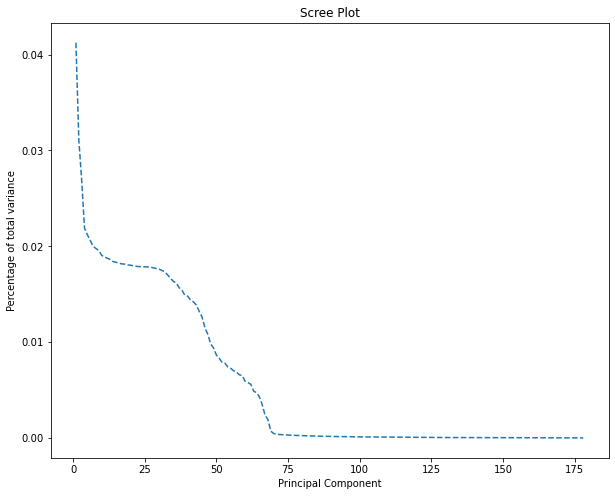

In [7]:
plt.figure(figsize=(10, 8))
PC_values = np.arange(pca_scree.n_components_) + 1
plt.plot(PC_values, pca_scree.explained_variance_ratio_, '--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Percentage of total variance')
plt.show()

According to the scree plot above, we can choose 70 pricipal components. This then gives the new (and hopefully better) new set of data.

In [36]:
pca = PCA(n_components=70)
reduced_train_feats_PCA  = pca.fit_transform(extended_train_feats)
reduced_val_feats_PCA  = pca.transform(extended_val_feats)
reduced_test_feats_PCA  = pca.transform(extended_test_feats)

In [16]:
table_reduced_data = {'Examples in train set': reduced_train_feats_PCA.shape[0], 'Examples in test set': test_feats.shape[0],'Examples in val set':reduced_val_feats_PCA.shape[0],'Features':reduced_train_feats_PCA.shape[1], 'Labels':reduced_train_labels.shape[1], 'Label cardinality':np.sum(reduced_train_labels)/reduced_train_feats_PCA.shape[0] , 'Label density':(np.sum(reduced_train_labels)/reduced_train_labels.shape[1])/reduced_train_feats_PCA.shape[0] }
pd.DataFrame(data = table_reduced_data,index=[' Modified PPI Data'])

,Examples in train set,Examples in test set,Examples in val set,Features,Labels,Label cardinality,Label density
Modified PPI Data,44906,5524,6514,70,72,22.655258,0.314656


The label cardinality has decreased and the label density has increased very slightly. There does not seem to be any issues from the modification.

### Implementing ML

There are open source implementations of methods for multi-label learning and evaluation such as MEKA and MULAN - the reference standard in the field. Both of these are not native to python and so to save time i have found a python library called scikit-multilearn which provides a wrapper and its own implementations.

In [17]:
# !pip install scikit-multilearn

# requirments:
# whichcraft==0.4.1
#scipy==1.1.0
#numpy>=1.15.1
#liac-arff==2.2.1
#networkx==2.1
#python-louvain==0.11
#future>=0.16.0
#scikit_learn>=0.19.2
#requests>=2.18.4

I know the method I am doing for hyper-paramer tuning is sacrilegious since i am using only the validation set for hyper parameter tuning (normally i would train the models with training data and test on vaidation data for paramter tuning) but due to time and computational limitations i am not able to carry this out fully.

#### Binary Relevance logistic regression classifier with hyper-parameter estimation using val data

Transforms a multi-label classification problem with L labels into L single-label separate binary classification problems using the same base classifier provided in the constructor. The prediction output is the union of all per label classifiers.

Here I test a simple (l2) logistic regression and a SVC. This method ignores relationships between labels.

In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

parameters_br = [
    {
        'classifier': [LogisticRegression()],
        'classifier__C': [0.1, 1, 10],
    },
    {
        'classifier': [SVC()],
        'classifier__kernel': ['rbf', 'linear'],
    },
]

score_br = 'f1_weighted'

model_br = GridSearchCV(BinaryRelevance(), parameters_br, scoring=score_br)

model_br.fit(reduced_val_feats_PCA, reduced_val_labels)

C:\Users\Nayef\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\Users\Nayef\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

In [ ]:
print (model_br.best_params_, model_br.best_score_)

#### Multi-label KNN classifier with hyper-parameter estimation using val data

MLkNN builds uses k-NearestNeighbors find nearest examples to a test class and uses Bayesian inference to select assigned labels.

It estimates one multi-class subclassifier - works when distance between samples is a good predictor for label assignment.

ref: $\textit{ML-KNN: A lazy learning approach to multi-label learning, Zhang et al.}$

The hyper parameters to tune here are k (number of neighbours of each input instance to take into account) and s (smoothing parameter).

In [47]:
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

parameters_knn = {'k': range(1,5), 's': [0.5, 0.7, 1.0]}

score_knn = 'f1_weighted'

model_knn = GridSearchCV(MLkNN(), parameters_knn, scoring=score_knn)
model_knn.fit(reduced_val_feats_PCA, reduced_val_labels)

GridSearchCV(estimator=MLkNN(),
             param_grid={'k': range(1, 5), 's': [0.5, 0.7, 1.0]},
             scoring='f1_weighted')

In [48]:
print (model_knn.best_params_, model_knn.best_score_)

{'k': 1, 's': 0.5} 0.48975054602967044


#### Twin multi-Label Support Vector Machines with hyper-parameter estimation using val data

MLTSVM determines multiple nonparallel hyperplanes to capture the multi-label information embedded in data, which is a useful promotion of twin support vector machine (TWSVM) for multi-label classification. 

It estimates one multi-label SVM subclassifier without any one-vs-all or one-vs-rest comparisons, O(1) classifiers instead of O(l^2). - works when distance between samples is a good predictor for label assignment.

ref:  $\textit{MLTSVM: A novel twin support vector machine to multi-label learning, Chen et al.}$

The hyper parameter to tune here is c_k (the empirical risk penalty parameter that determines the trade-off between the loss terms).

In [ ]:
from skmultilearn.adapt import MLTSVM

parameters_svm = {'c_k': [2**i for i in range(-5, 5, 2)]}
score_svm = 'f1_macro'

model_svm = GridSearchCV(MLTSVM(), parameters_svm, scoring=score_svm)
model_svm.fit(sparse.csr_matrix(reduced_val_feats_PCA), sparse.csr_matrix(reduced_val_labels)) # input is only sparce matrices

In [ ]:
print (model_svm.best_params_, model_svm.best_score_)

Running this grid search takes a very long time so I decided agaisnt it this time due to time and computational constraints. I would be inetresting to see the output!

According to the models I tested, the Multi-label KNN classifier with one neighbour and s=0.5 gave the best f1 weighted score which is what was expected since the binary relevance method is label relationship agnostic. The computed f1 score is also comparable to the f1 score obtained in the node2vec paper for PPI data (they used f1 macro which ignores label imbalances). 

#### Training and Evaluation 

There are several evaluation metrics that are used for milti-label problems. The main metrics are the hamming loss which measures how well the classifier predicts each of the labels, averaged over samples, then over labels and the F1 score which measures a weighted average of precision and recall, where both have the same impact on the score. I use the weighted f1 score which calculates metrics for each label, and finds their average weighted by their support, which helps with label imbalance. These are the scores we consider here (even though there are many more).

ref: $\textit{Multi-Label Classification: An Overview, Tsoumakas et al}$

I am choosing to train the MLkNN model due to the highest f1 weighted score obtained as well as being very fast. I decided to run the binary relevance again but it has taken an extremely long time so i ended the computation but from a previous run, the f1 score was lower than that of MLkNN. We can now train MLkNN on the training data:

In [35]:
from skmultilearn.adapt import MLkNN


classifier = MLkNN(k=1,s=0.5)

# train
classifier.fit(reduced_train_feats_PCA, reduced_train_labels)

MLkNN(k=1, s=0.5)

In [37]:
# predict
predictions = classifier.predict(reduced_test_feats_PCA)
predictions.todense()

In [46]:
# Compute metrics
import sklearn.metrics as metrics

print('Hamming loss:', metrics.hamming_loss(reduced_test_labels, predictions))
print('F1-weighted score:', metrics.f1_score(reduced_test_labels, predictions, average = 'weighted'))

Hamming loss: 0.2962074583635047
F1-weighted score: 0.5041589593763145


In [51]:
# saving pre-trained model
Pkl_Filename = "Pickle_MLkNN_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(classifier, file)

These scores are actually not bad considering the scores presented in literature such as in the node2vec paper where they report f1 scores in the 0.25-0.4 range. Now we can invert the label space reducion and evaluate the results again,  have run out of time here but I have put the function for this below.

In [ ]:
full_predicted = np.insert(predictions,inx_unique, predictions[np.unique(inx[0])])